## README!

This notebook uses the Oanada datafeed from their v20 API. You will need to get a dev token to run this code. You will need to put your account # and dev token into two seperate files called account.txt and token.txt in a sub folder called 'oanda_account.' You may change this by make sure to update the def exampleAuth function. 

Install Py Package from: https://github.com/hootnot/oanda-api-v20 and the ReadTheDocs are here: https://oanda-api-v20.readthedocs.io/en/latest/oanda-api-v20.html

This is the first version of the Autogenerating Support and Resistance Lines and it makes a matplotlib chart. The  subsquent notebook will contain Bokeh charting.

### To Do

There are many things I need to do to clean up this notebook for my readers. Especially explaining what I'm doing here and what I tweaked out. So look for updates or ping me on Twitter @neuralmarket


In [36]:
#Initialize python libraries

import json
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
from oandapyV20.contrib.factories import InstrumentsCandlesFactory

import datetime as DT

import pandas as pd
from pandas.io.json import json_normalize

from scipy.signal import savgol_filter as smooth
import matplotlib.pyplot as plt

import numpy as np

In [37]:
#This function just reads your account.txt and token.txt file. I have NOT included this in the repo, you will have to provide your own.
def exampleAuth():
    accountID, token = None, None
    with open("./oanda_account/account.txt") as I:
        accountID = I.read().strip()
    with open("./oanda_account/token.txt") as I:
        token = I.read().strip()
    return accountID, token

In [38]:
#Connect to your Account!

accountID, access_token = exampleAuth()
client = oandapyV20.API(access_token=access_token)

In [39]:
#Some datetime work. I tried to make this simple so I grab today's date and then go back 720 days to generate the chart. That's two years!
today = DT.date.today()
two_years_ago = today - DT.timedelta(days=720)

t = today.timetuple()
y = two_years_ago.timetuple()

In [40]:
instrument = "EUR_USD"
params = {
    "from": two_years_ago,
    "granularity": "D",
    "count": 720,
}

r = instruments.InstrumentsCandles(instrument=instrument, params=params)
response = client.request(r)

In [41]:
df = pd.DataFrame(response['candles']).set_index('time')

In [42]:
df = df['mid']

In [43]:
time_df = pd.DataFrame(response['candles'])
time = time_df['time']

In [44]:
df = json_normalize(df).astype(float)

In [45]:
df = pd.merge(df, time, how='inner', left_index=True, right_index=True)

In [46]:
df['just_date'] = pd.to_datetime(df['time']).dt.date

In [50]:
df.dtypes

c            float64
h            float64
l            float64
o            float64
time          object
just_date     object
dtype: object

In [51]:
close = df['c']

In [52]:
data = close.to_numpy()

In [53]:
#Set Lookback period
time = 20

In [54]:
def support(ltp, n):
    """
    This function takes a numpy array of last traded price
    and returns a list of support and resistance levels 
    respectively. n is the number of entries to be scanned.
    """

    # converting n to a nearest even number
    if n % 2 != 0:
        n += 1

    n_ltp = ltp.shape[0]

    # smoothening the curve
    ltp_s = smooth(ltp, (n + 1), 3)

    # taking a simple derivative
    ltp_d = np.zeros(n_ltp)
    ltp_d[1:] = np.subtract(ltp_s[1:], ltp_s[:-1])

    resistance = []
    support = []

    for i in range(n_ltp - n):
        arr_sl = ltp_d[i:(i + n)]
        first = arr_sl[:(n // 2)]  # first half
        last = arr_sl[(n // 2):]  # second half

        r_1 = np.sum(first > 0)
        r_2 = np.sum(last < 0)

        s_1 = np.sum(first < 0)
        s_2 = np.sum(last > 0)

        # local maxima detection
        if (r_1 == (n // 2)) and (r_2 == (n // 2)):
            resistance.append(ltp[i + ((n // 2) - 1)])

        # local minima detection
        if (s_1 == (n // 2)) and (s_2 == (n // 2)):
            support.append(ltp[i + ((n // 2) - 1)])

    return support


In [55]:
sup = support(data, time)

In [56]:
df_sup = pd.DataFrame(sup)
df_sup

,0
0,1.08986
1,1.07916


In [57]:
def resistance(ltp, n):
    """
    This function takes a numpy array of last traded price
    and returns a list of support and resistance levels 
    respectively. n is the number of entries to be scanned.
    """

    # converting n to a nearest even number
    if n % 2 != 0:
        n += 1

    n_ltp = ltp.shape[0]

    # smoothening the curve
    ltp_s = smooth(ltp, (n + 1), 3)

    # taking a simple derivative
    ltp_d = np.zeros(n_ltp)
    ltp_d[1:] = np.subtract(ltp_s[1:], ltp_s[:-1])

    resistance = []
    support = []

    for i in range(n_ltp - n):
        arr_sl = ltp_d[i:(i + n)]
        first = arr_sl[:(n // 2)]  # first half
        last = arr_sl[(n // 2):]  # second half

        r_1 = np.sum(first > 0)
        r_2 = np.sum(last < 0)

        s_1 = np.sum(first < 0)
        s_2 = np.sum(last > 0)

        # local maxima detection
        if (r_1 == (n // 2)) and (r_2 == (n // 2)):
            resistance.append(ltp[i + ((n // 2) - 1)])

        # local minima detection
        if (s_1 == (n // 2)) and (s_2 == (n // 2)):
            support.append(ltp[i + ((n // 2) - 1)])

    return resistance

In [58]:
res = resistance(data, time)

In [59]:
df_res = pd.DataFrame(res)
df_res

,0
0,1.17776
1,1.13694
2,1.10795
3,1.11512
4,1.14400


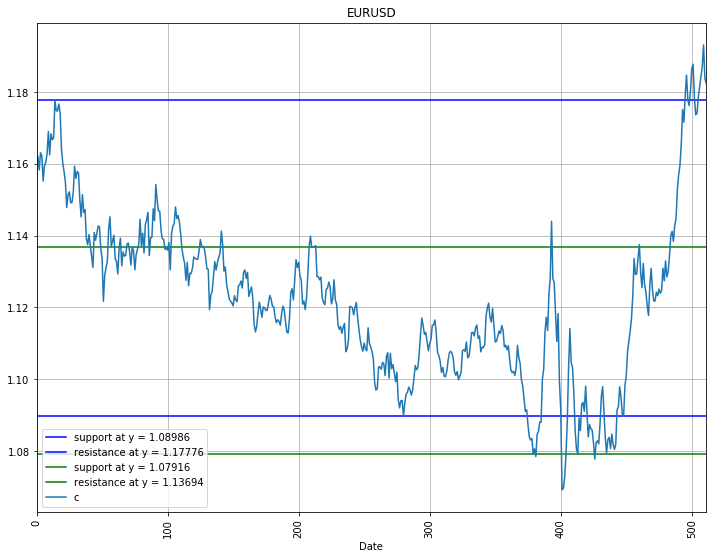

In [71]:
title = 'EURUSD'
ycoords_sup = sup
ycoords_res = res
# colors for the lines
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

for ycs,ycr,c in zip(ycoords_sup,ycoords_res,colors):
    plt.axhline(y=ycs, label='support at y = {}'.format(ycs), c=c)
    plt.axhline(y=ycr, label='resistance at y = {}'.format(ycr), c=c)
close.plot(figsize=(12,9),grid=True, title = title)

plt.xticks(rotation=90)
plt.xlabel('Date')
plt.legend()

# Create new directory
#output_dir = "/home/routinelife/labs.neuralmarkettrends.com"
# mkdir_p(output_dir)


#plt.savefig(+ title + '-chart.png')
plt.show()
#fig.savefig('{}/graph.png'.format(output_dir))

In [80]:
from bokeh.plotting import figure, show, output_file, output_notebook
from bokeh.models import Span
from math import pi
output_notebook()

Loading BokehJS ...

In [81]:
inc = df.c > df.o
dec = df.o > df.c
w = 12*60*60*1000 # half day in ms

TOOLS = "pan,wheel_zoom,box_zoom,reset,save"

In [82]:
p = figure(x_axis_type="datetime", tools=TOOLS, plot_width=1000, title = instrument + "Currency Pair")
p.xaxis.major_label_orientation = pi/4
p.grid.grid_line_alpha=0.3

In [83]:
p.segment(df.just_date, df.h, df.just_date, df.l, color="black")
p.vbar(df.just_date[inc], w, df.o[inc], df.c[inc], fill_color="#D5E1DD", line_color="black")
p.vbar(df.just_date[dec], w, df.o[dec], df.c[dec], fill_color="#F2583E", line_color="black")

for i in df_res[0]:
    #print (i)
    hline_res = Span(location=i, dimension='width', line_color='green', line_width=3)
    hline_sup = Span(location=i, dimension='width', line_color='red', line_width=3)
    p.renderers.extend([hline_res])
    
for i in df_sup[0]:
    #print (i)
    hline_sup = Span(location=i, dimension='width', line_color='red', line_width=3)
    p.renderers.extend([hline_sup])

#p.renderers.extend([hline])

In [84]:
#output_file(instrument+".html", title=instrument+" Currency Pair")

show(p, notebook_handle=True)  # open a browser

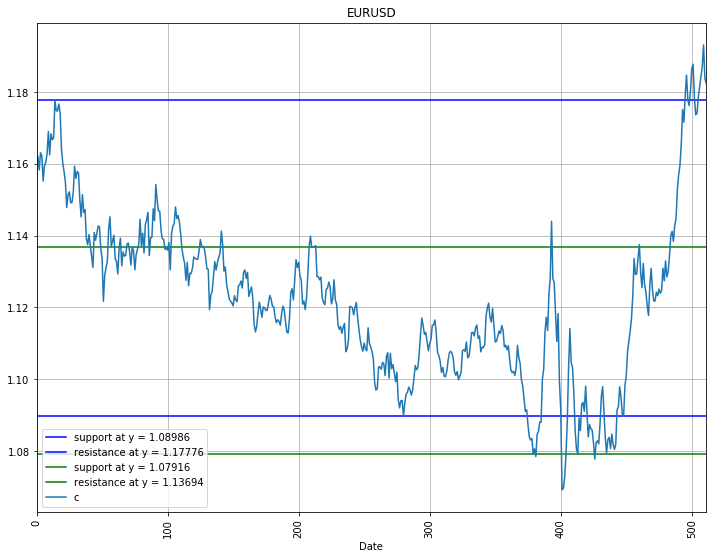

In [ ]:
#TODO, add in 'squishy zones'